In [16]:
import os
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql.functions import (col, lead, hour, dayofweek, when, sin, cos, lit)
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, TimestampType, FloatType
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

from dotenv import load_dotenv

import warnings
warnings.filterwarnings("ignore")

In [17]:
spark = (
    SparkSession.builder
    .appName("BikeUtilizationNextHour")
    .master("local[*]")            
    .getOrCreate()
)
spark.sparkContext.setLogLevel("ERROR")  
print("✅ Spark session started")

BASE = os.getcwd()
DATASET = os.path.join(BASE, "..", "csv", "usage_summary.csv")
MODEL_DIR = os.path.join(BASE, "model_next_hour_rf")

print("Using dataset:", os.path.abspath(DATASET))
print("Model will be saved to:", os.path.abspath(MODEL_DIR))

✅ Spark session started
Using dataset: /home/sarantis/Documents/Spark_Project/csv/usage_summary.csv
Model will be saved to: /home/sarantis/Documents/Spark_Project/machine_learning/model_next_hour_rf


In [18]:
schema = StructType([
    StructField("window_start", TimestampType(), True),
    StructField("window_end", TimestampType(), True),
    StructField("city", StringType(), True),
    StructField("avg_util", DoubleType(), True),
    StructField("max_util", DoubleType(), True),
    StructField("min_util", DoubleType(), True),
    StructField("std_util", DoubleType(), True),
    StructField("avg_temp", DoubleType(), True),
    StructField("avg_wind", DoubleType(), True),
    StructField("avg_clouds", DoubleType(), True),
    StructField("avg_rain", DoubleType(), True)
])
print("✅ Paths and schema ready")

df = spark.read.csv(DATASET, header=True, schema=schema)
df = df.orderBy(col("window_start").asc())
df.show(5, truncate=False)

✅ Paths and schema ready
+-------------------+-------------------+-----+-------------------+--------+-------------------+-------------------+--------+--------+----------+--------+
|window_start       |window_end         |city |avg_util           |max_util|min_util           |std_util           |avg_temp|avg_wind|avg_clouds|avg_rain|
+-------------------+-------------------+-----+-------------------+--------+-------------------+-------------------+--------+--------+----------+--------+
|2024-10-01 00:00:00|2024-10-01 00:30:00|Dubai|0.12701971200407824|0.7     |0.0751488588740989 |0.13780409198416974|13.35   |4.02    |4.52      |0.0     |
|2024-10-01 00:30:00|2024-10-01 01:00:00|Dubai|0.20358897827893918|0.7     |0.11718720278539041|0.11376687028255095|15.51   |3.93    |9.86      |0.0     |
|2024-10-01 01:00:00|2024-10-01 01:30:00|Dubai|0.2890309473644737 |0.7     |0.2380438898149237 |0.10407713343927097|14.9    |3.86    |34.62     |0.0     |
|2024-10-01 01:30:00|2024-10-01 02:00:00|Duba

In [19]:

w = Window.orderBy(col("window_start").asc())

df = (
    df
    # weather forecast at t+1h (2 rows later → 1 hour)
    .withColumn("temp_t1h",  lead("avg_temp",  2).over(w))
    .withColumn("wind_t1h",  lead("avg_wind",  2).over(w))
    .withColumn("rain_t1h",  lead("avg_rain",  2).over(w))
    .withColumn("clouds_t1h",lead("avg_clouds",2).over(w))
    
    # timestamp of the prediction moment (t+1h)
    .withColumn("time_t1h",  lead("window_start", 2).over(w))

    # LABEL we want to predict: bike utilization at t+1h
    .withColumn("util_t1h",  lead("avg_util", 2).over(w))
)

df = df.na.drop(subset=["temp_t1h", "wind_t1h", "rain_t1h", "time_t1h", "util_t1h"])
print("✅ Future (t+1h) features created!")
df.show(5, truncate=False)

✅ Future (t+1h) features created!
+-------------------+-------------------+-----+-------------------+--------+-------------------+-------------------+--------+--------+----------+--------+--------+--------+--------+----------+-------------------+-------------------+
|window_start       |window_end         |city |avg_util           |max_util|min_util           |std_util           |avg_temp|avg_wind|avg_clouds|avg_rain|temp_t1h|wind_t1h|rain_t1h|clouds_t1h|time_t1h           |util_t1h           |
+-------------------+-------------------+-----+-------------------+--------+-------------------+-------------------+--------+--------+----------+--------+--------+--------+--------+----------+-------------------+-------------------+
|2024-10-01 00:00:00|2024-10-01 00:30:00|Dubai|0.12701971200407824|0.7     |0.0751488588740989 |0.13780409198416974|13.35   |4.02    |4.52      |0.0     |14.9    |3.86    |0.0     |34.62     |2024-10-01 01:00:00|0.2890309473644737 |
|2024-10-01 00:30:00|2024-10-01 01

In [20]:
df = df.withColumn("hour_t1h", hour(col("time_t1h")))
df = df.withColumn("dow_t1h", dayofweek(col("time_t1h")))  

df = df.withColumn(
    "is_weekend_t1h",
    when(col("dow_t1h").isin([1, 7]), 1.0).otherwise(0.0)
)

print("✅ Time feature engineering completed!")
df.select(
    "time_t1h", "hour_t1h", "dow_t1h", "is_weekend_t1h",
).show(5, truncate=False)

✅ Time feature engineering completed!
+-------------------+--------+-------+--------------+
|time_t1h           |hour_t1h|dow_t1h|is_weekend_t1h|
+-------------------+--------+-------+--------------+
|2024-10-01 01:00:00|1       |3      |0.0           |
|2024-10-01 01:30:00|1       |3      |0.0           |
|2024-10-01 02:00:00|2       |3      |0.0           |
|2024-10-01 02:30:00|2       |3      |0.0           |
|2024-10-01 03:00:00|3       |3      |0.0           |
+-------------------+--------+-------+--------------+
only showing top 5 rows



In [21]:
feature_cols = [
    "temp_t1h",
    "wind_t1h",
    "rain_t1h",
    "clouds_t1h",
    "hour_t1h",
    "is_weekend_t1h"
]
prediction = "util_t1h"

print("Selected features:", feature_cols)
print("Predicted feature:", prediction)

train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
print(f"✅ Train rows: {train_df.count()}  |  Test rows: {test_df.count()}")

Selected features: ['temp_t1h', 'wind_t1h', 'rain_t1h', 'clouds_t1h', 'hour_t1h', 'is_weekend_t1h']
Predicted feature: util_t1h
✅ Train rows: 2391  |  Test rows: 535


In [22]:
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

rf = RandomForestRegressor(
    featuresCol="features",
    labelCol=prediction,
    numTrees=120,
    maxDepth=8,
    seed=42
)

pipeline = Pipeline(stages=[assembler, rf])
print("✅ Pipeline created (VectorAssembler + RandomForestRegressor)")

model = pipeline.fit(train_df)
print("✅ Model training complete!")

✅ Pipeline created (VectorAssembler + RandomForestRegressor)
✅ Model training complete!


In [23]:
test_predictions = model.transform(test_df)

rmse_evaluator = RegressionEvaluator(
    labelCol=prediction,
    predictionCol="prediction",
    metricName="rmse"
)

r2_evaluator = RegressionEvaluator(
    labelCol=prediction,
    predictionCol="prediction",
    metricName="r2"
)

mae_evaluator = RegressionEvaluator(
    labelCol=prediction,
    predictionCol="prediction",
    metricName="mae"
)

rmse = rmse_evaluator.evaluate(test_predictions)
r2 = r2_evaluator.evaluate(test_predictions)
mae = mae_evaluator.evaluate(test_predictions)

print("✅ Model Evaluation Results:")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"MAE Score: {mae:.4f}")

test_predictions.select(
    "util_t1h", "prediction", "time_t1h"
).show(5, truncate=False)


✅ Model Evaluation Results:
RMSE: 0.0737
R² Score: 0.7270
MAE Score: 0.0585
+-------------------+-------------------+-------------------+
|util_t1h           |prediction         |time_t1h           |
+-------------------+-------------------+-------------------+
|0.373608649224309  |0.3471921085700041 |2024-10-01 02:00:00|
|0.36164196735399173|0.26448494309054454|2024-10-01 04:00:00|
|0.23944004308866432|0.2623739858991277 |2024-10-01 05:00:00|
|0.3467799459866746 |0.26906287343220936|2024-10-01 07:30:00|
|0.005486111199901  |0.18013925670490202|2024-10-01 10:30:00|
+-------------------+-------------------+-------------------+
only showing top 5 rows



In [24]:
if os.path.exists(MODEL_DIR):
    shutil.rmtree(MODEL_DIR)  

model.write().overwrite().save(MODEL_DIR)

print(f"✅ Model saved to: {os.path.abspath(MODEL_DIR)}")

latest = df.orderBy(col("time_t1h").desc()).limit(1)

print("\n🧪 Example: On-demand prediction")
latest.select(
    "time_t1h", "temp_t1h", "wind_t1h", "rain_t1h", "hour_t1h", "is_weekend_t1h"
).show(truncate=False)

predicted = model.transform(latest).select("prediction").collect()[0][0]

print(f"\n🚴‍♂️ Predicted utilization for next hour: {predicted:.4f}")


✅ Model saved to: /home/sarantis/Documents/Spark_Project/machine_learning/model_next_hour_rf

🧪 Example: On-demand prediction
+-------------------+--------+--------+--------+--------+--------------+
|time_t1h           |temp_t1h|wind_t1h|rain_t1h|hour_t1h|is_weekend_t1h|
+-------------------+--------+--------+--------+--------+--------------+
|2024-11-30 23:30:00|18.84   |7.36    |0.0     |23      |1.0           |
+-------------------+--------+--------+--------+--------+--------------+


🚴‍♂️ Predicted utilization for next hour: 0.1085


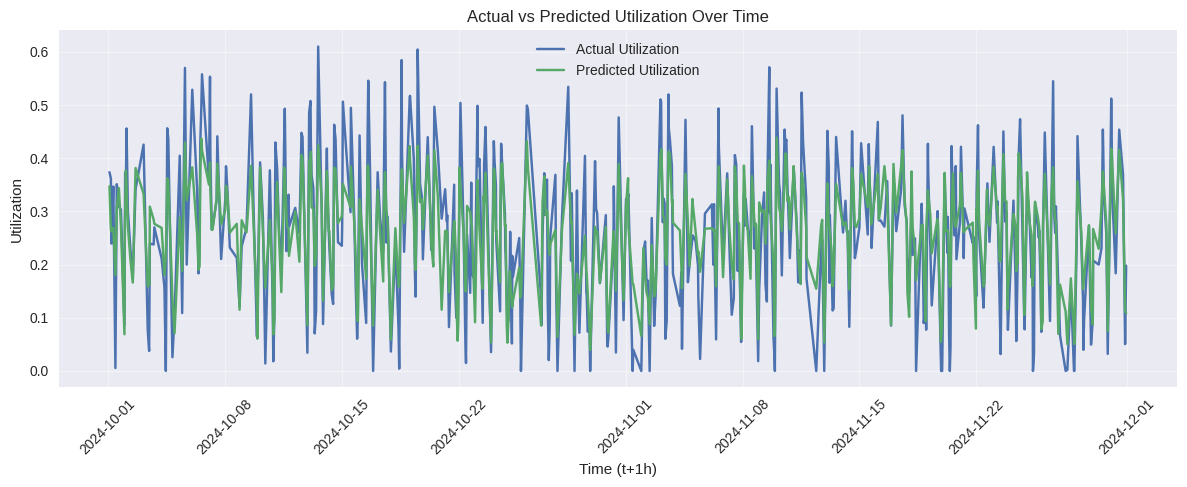

In [25]:
plt.style.use("seaborn-v0_8") 
plt.rcParams["figure.figsize"] = (12, 5) 
plt.rcParams["axes.grid"] = True 
plt.rcParams["grid.alpha"] = 0.4 
plt.rcParams["font.size"] = 11

pdf = test_predictions.select("util_t1h", "prediction", "time_t1h").toPandas()
pdf = pdf.sort_values("time_t1h")

plt.figure(figsize=(12, 5))
plt.plot(pdf["time_t1h"], pdf["util_t1h"], label="Actual Utilization")
plt.plot(pdf["time_t1h"], pdf["prediction"], label="Predicted Utilization")
plt.title("Actual vs Predicted Utilization Over Time")
plt.xlabel("Time (t+1h)")
plt.ylabel("Utilization")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

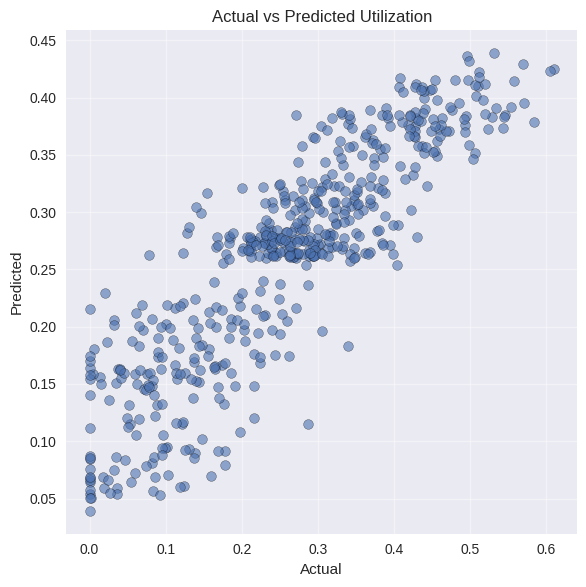

In [26]:
plt.figure(figsize=(6, 6)) 
plt.scatter(pdf["util_t1h"], pdf["prediction"], alpha=0.6, edgecolor="black") 
plt.title("Actual vs Predicted Utilization") 
plt.xlabel("Actual") 
plt.ylabel("Predicted") 
plt.tight_layout() 
plt.show()

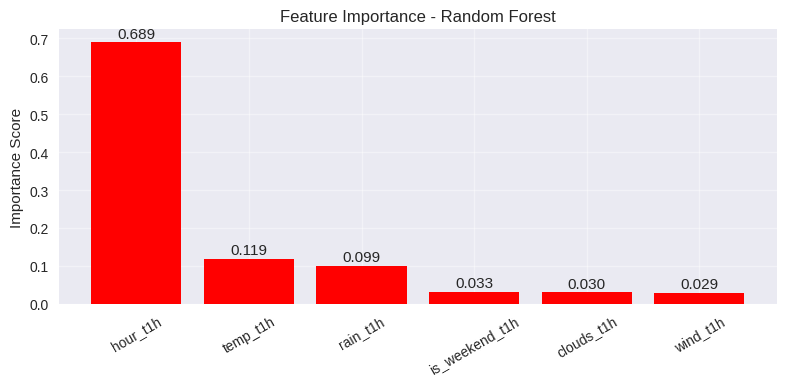

In [27]:
rf_model = model.stages[-1] 
importances = np.array(rf_model.featureImportances.toArray()) 
features = np.array(feature_cols) 
indices = np.argsort(importances)[::-1] 
plt.figure(figsize=(8, 4)) 
bars = plt.bar(features[indices], importances[indices], color="red") 
plt.title("Feature Importance - Random Forest") 
plt.ylabel("Importance Score") 
plt.xticks(rotation=30) 
for bar in bars: 
    height = bar.get_height() 
    plt.text(bar.get_x() + bar.get_width()/2, 
             height + 0.005, f"{height:.3f}", 
             ha="center", va="bottom") 
    
plt.tight_layout() 
plt.show()

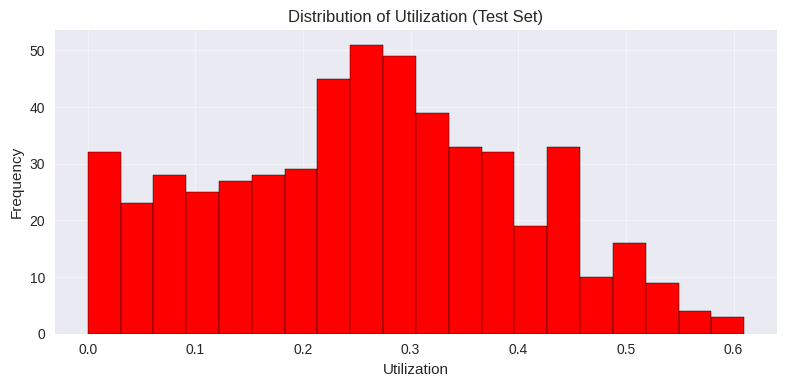

In [28]:
plt.figure(figsize=(8, 4)) 
plt.hist(pdf["util_t1h"], bins=20, color="red", edgecolor="black") 
plt.title("Distribution of Utilization (Test Set)") 
plt.xlabel("Utilization") 
plt.ylabel("Frequency") 
plt.tight_layout() 
plt.show()